## OVERVIEW
This notebook performs optimization for model 1 -- Maximizing marginal access by placing new grocery stores

### How this works (implementation):

1. Use the helper_population_allocation.py to allocate a population count to each residential building 
2. Use the helper_distance_calculation.py to calculate existing access and distance between a residential and commercial building
3. Once 1 and 2 are done, all parameters are ready. 

### Outputs

1. Using a access definition of 0.5 mile, where would a new store be placed to maximize marginal access 
2. Additionally, the notebook also outputs the same decision, but for 3 new stores
3. Note: The notebook also explores a 1 mile definition, but for this project's purposes, we will consider the 0.5 mile definition as that's more conservative. 

In [27]:
# Import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import haversine as hs
import gurobipy as gp
from gurobipy import GRB

# Helper modules
import helper_population_allocation as pa
import helper_distance_calculation as dc

# Avoid printing set copy warnings
import warnings
warnings.filterwarnings("ignore")



PRE-OPTIMIZATION SETUP

In [28]:
%%time

# Get the main buildings dataset 
buildings_df = gpd.read_file('../processed_data/relevant_buildings.shp')

# Create ID variable
buildings_df.reset_index(drop=True, inplace=True)
buildings_df['building_id'] = buildings_df.index + 1
buildings_df['building_id'] = buildings_df.apply(lambda row: str(row['building_id']) + '-' + str(row['CLASS']) , axis=1)

Wall time: 15.9 s


In [29]:
# Create arrays to track ordering (residential)
res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings = res_buildings.sort_values('building_id')
res_buildings = dc.get_geocoordinate(res_buildings, 'geometry')

res_buildings_array = np.array(res_buildings['building_id'])
res_buildings_coordinates_array = np.array(res_buildings['coordinates'])

In [30]:
# Create arrays to track ordering (Commercial)
comm_buildings = buildings_df[buildings_df['class_reco'].str.contains('commercial')]
comm_buildings = comm_buildings.sort_values('building_id')
comm_buildings = dc.get_geocoordinate(comm_buildings, 'geometry')

comm_buildings_array = np.array(comm_buildings['building_id'])
comm_buildings_coordinates_array = np.array(comm_buildings['coordinates'])


In [31]:
# Create arrays to track ordering (grocery stores)
grocery_stores = buildings_df[buildings_df['class_reco'].str.contains('Grocery')]
grocery_stores = grocery_stores.sort_values('building_id')
grocery_stores = dc.get_geocoordinate(grocery_stores, 'geometry')

grocery_stores_array = np.array(grocery_stores['building_id'])
grocery_stores_coordinates_array = np.array(grocery_stores['coordinates'])


In [17]:
%%time
# DONT RUN THIS AGAIN
# WE have run this and stored the matrices

# Create parameter matrices (Res comm access matrix - Bij)
# [i,j] value indicates whether residential building i is within access distance of commercial building j
# res_comm_distance_matrix, res_comm_access_matrix = dc.calculate_access(res_buildings_coordinates_array, comm_buildings_coordinates_array)

# # Save file
# np.save('res_comm_access_matrix', res_comm_access_matrix)
# np.save('res_comm_distance_matrix', res_comm_distance_matrix)


Wall time: 0 ns


In [32]:
# Load the files and use it 
res_comm_access_matrix = np.load('res_comm_access_matrix.npy') 
res_comm_distance_matrix = np.load('res_comm_distance_matrix.npy')  # [i,j] corresponds to distance between ith residential building and jth commercial building

In [33]:
%%time

# Create parameter matrices (Res groc access array - Ai)
# ith value indicates whether the ith residential building has existing access
res_groc_distance_matrix, res_groc_access_matrix = dc.calculate_access(res_buildings_coordinates_array, grocery_stores_coordinates_array)
res_access_array = np.amax(res_groc_access_matrix, 1)


Wall time: 45.8 s


In [35]:
%%time

# Create parameter matrices (Res Population - Pi)
# ith value indicates the population of the ith residential building
res_population = pa.get_population(buildings_df) 
res_population = res_population.drop_duplicates('building_id') # drop duplicates

res_population = res_population.sort_values('building_id') # Just to be safe
res_population_array = np.array(res_population['population'])
res_population_array.shape


Wall time: 28.5 s


(109324,)

OPTIMIZATION

Steps:
i = set of all residential buildings,
j = set of all commercial buildings

Decision variable:
- Cj = 1 if the new grocery store is put in commercial building j, 0 otherwise

Parameters:
- Ai = 1 if residential building i already has access to a food store (within 0.5 mile)
- Bij = 1 if commercial building j is within 0.5 mile of residential building i
- Pi = Population at building i

Objective function:

Max $$ \sum_j \sum_i (1-A_i)*P_i*B_{ij}*C_j$$






In [36]:
# Function that can put n stores in a greedy way

def place_n_stores(num_stores, access_matrix, access_array):

    store_indices = []
    store_ids = []
    marginal_access_gain = []

    res_access_array_copy = access_array.copy()
    for n in range(num_stores):

        if np.sum(res_access_array_copy) == len(res_buildings_array): # This means every building now has access
            pass
        else:
            # STEP 1
            existing_access_indices = res_access_array_copy.nonzero()[0] # These are indices of residential buildings that currently have access
            res_comm_access_matrix_subset = np.delete(access_matrix, existing_access_indices, axis=0 )

            # STEP 2
            res_population_array_sub = np.delete(res_population_array, existing_access_indices, axis=0)

            # STEP 3
            res_population_array_sub = np.reshape(res_population_array_sub, (-1, len(res_population_array_sub)))
            new_access_array = np.matmul(res_population_array_sub, res_comm_access_matrix_subset)

            chosen_comm_index = np.argmax(new_access_array)
            chosen_comm_building = comm_buildings_array[chosen_comm_index]
            new_access_created = np.max(new_access_array)

            # STEP 4: Update results and arrays
            
            # Which residential buildings does this new store give access to
            new_buildings_with_access = access_matrix[:,chosen_comm_index].nonzero()[0]    # These are the indices in the res_access_array that need to be replaced (these buildings now have access)

            # Update the access values of these buildings in the access array
            replace_vals = list(np.ones(new_buildings_with_access.shape)) # These are the values which with certain elements of the access array will be replaced with

            # Perform replace
            res_access_array_copy[new_buildings_with_access] = replace_vals

            # STEP 5: Store results
            store_indices.append(chosen_comm_index)
            store_ids.append(chosen_comm_building)
            marginal_access_gain.append(new_access_created)



    return store_indices, store_ids, marginal_access_gain





In [37]:
# STARTING WITH 1 MILE DEFINITION

store_indices, store_ids, marginal_access_gain = place_n_stores(5, access_array=res_access_array, access_matrix=res_comm_access_matrix)

print(f"Num additional stores needed to fill complete access = {len(store_indices)}")

results_df = pd.DataFrame(list(zip(store_ids, marginal_access_gain)),
                                columns = ['building_id', 'marginal_access_gain'])
                                
results_df


Num additional stores needed to fill complete access = 2


,building_id,marginal_access_gain
0,2816-R,5366.47
1,116276-C,1868.91


In [38]:
# WHAT IF THERE WERE NO GROCERY STORES TO BEGIN WITH. HOW MANY MINIMUM NUMBER OF STORES ARE NEEDED AND WHERE TO COMPLETE ACCESS

res_access_array_zero = np.zeros(res_access_array.shape)

store_indices, store_ids, marginal_access_gain = place_n_stores(50, access_array=res_access_array_zero, access_matrix=res_comm_access_matrix)

print(f"Num additional stores needed to fill complete access = {len(store_indices)}")

results_df = pd.DataFrame(list(zip(store_ids, marginal_access_gain)),
                                columns = ['building_id', 'marginal_access_gain'])
                                
results_df

Num additional stores needed to fill complete access = 14


,building_id,marginal_access_gain
0,94210-C,80679.81
1,70644-C,51364.49
2,60631-C,49108.81
3,25462-C,40248.54
4,110538-C,37527.28
5,81793-C,29240.34
6,3960-C,9593.14
7,22083-C,5012.29
8,96804-C,4510.78
9,32252-C,3973.71


In [40]:
# CHANGING THE ACCESS DEFINITION TO 0.5 MILES FROM 1 MILE

# Import res comm access matrix again (just to be safe)
res_comm_access_matrix = np.load('res_comm_access_matrix.npy')
res_comm_distance_matrix = np.load('res_comm_distance_matrix.npy')

# Creating a modified res comm access matrix 
res_comm_access_matrix_half_mile = res_comm_distance_matrix.copy()
res_comm_access_matrix_half_mile[res_comm_access_matrix_half_mile <= 0.5] = 1
res_comm_access_matrix_half_mile[res_comm_access_matrix_half_mile != 1] = 0

# Create a modified res existing access array
res_groc_distance_matrix, res_groc_access_matrix = dc.calculate_access(res_buildings_coordinates_array, grocery_stores_coordinates_array)

res_groc_access_matrix_half_mile = res_groc_distance_matrix.copy()
res_groc_access_matrix_half_mile[res_groc_access_matrix_half_mile <= 0.5] = 1
res_groc_access_matrix_half_mile[res_groc_access_matrix_half_mile != 1] = 0

res_access_array_half_mile = np.amax(res_groc_access_matrix_half_mile, 1)


# Calculate 
store_indices, store_ids, marginal_access_gain = place_n_stores(50, access_array=res_access_array_half_mile,
                                                                     access_matrix=res_comm_access_matrix_half_mile)

print(f"Num additional stores needed to fill complete access = {len(store_indices)}")

results_df = pd.DataFrame(list(zip(store_ids, marginal_access_gain)),
                                columns = ['building_id', 'marginal_access_gain'])

results_df.to_csv('new_store_ids.csv')                      
results_df




Num additional stores needed to fill complete access = 21


,building_id,marginal_access_gain
0,31851-C,8040.70
1,105592-R,6919.09
2,3018-R,5697.39
3,19415-C,5319.45
4,110387-C,4887.92
5,14692-C,4366.10
6,65810-C,4301.95
7,109-C,1997.31
8,3898-C,1902.04
9,2877-C,1284.82


In [41]:
# IF THERE WERE NO EXISTING STORES
# Import res comm access matrix again (just to be safe)
res_comm_access_matrix = np.load('res_comm_access_matrix.npy')
res_comm_distance_matrix = np.load('res_comm_distance_matrix.npy')

# Creating a modified res comm access matrix 
res_comm_access_matrix_half_mile = res_comm_distance_matrix.copy()
res_comm_access_matrix_half_mile[res_comm_access_matrix_half_mile <= 0.5] = 1
res_comm_access_matrix_half_mile[res_comm_access_matrix_half_mile != 1] = 0

res_access_array_zero = np.zeros(res_access_array.shape)


store_indices, store_ids, marginal_access_gain = place_n_stores(100, access_array=res_access_array_zero,
                                                                     access_matrix=res_comm_access_matrix_half_mile)

print(f"Num additional stores needed to fill complete access = {len(store_indices)}")

results_df = pd.DataFrame(list(zip(store_ids, marginal_access_gain)),
                                columns = ['building_id', 'marginal_access_gain'])

results_df.to_csv('new_store_id_assuming_no_existing_access.csv')      
results_df






Num additional stores needed to fill complete access = 48


,building_id,marginal_access_gain
0,112491-C,42913.48
1,103358-C,26982.53
2,60523-C,24095.10
3,101372-C,22349.77
4,36990-C,19643.89
5,113664-C,19577.45
6,80815-C,18112.11
7,52332-C,15308.27
8,76745-C,15249.77
9,15668-C,13861.77


<AxesSubplot:>

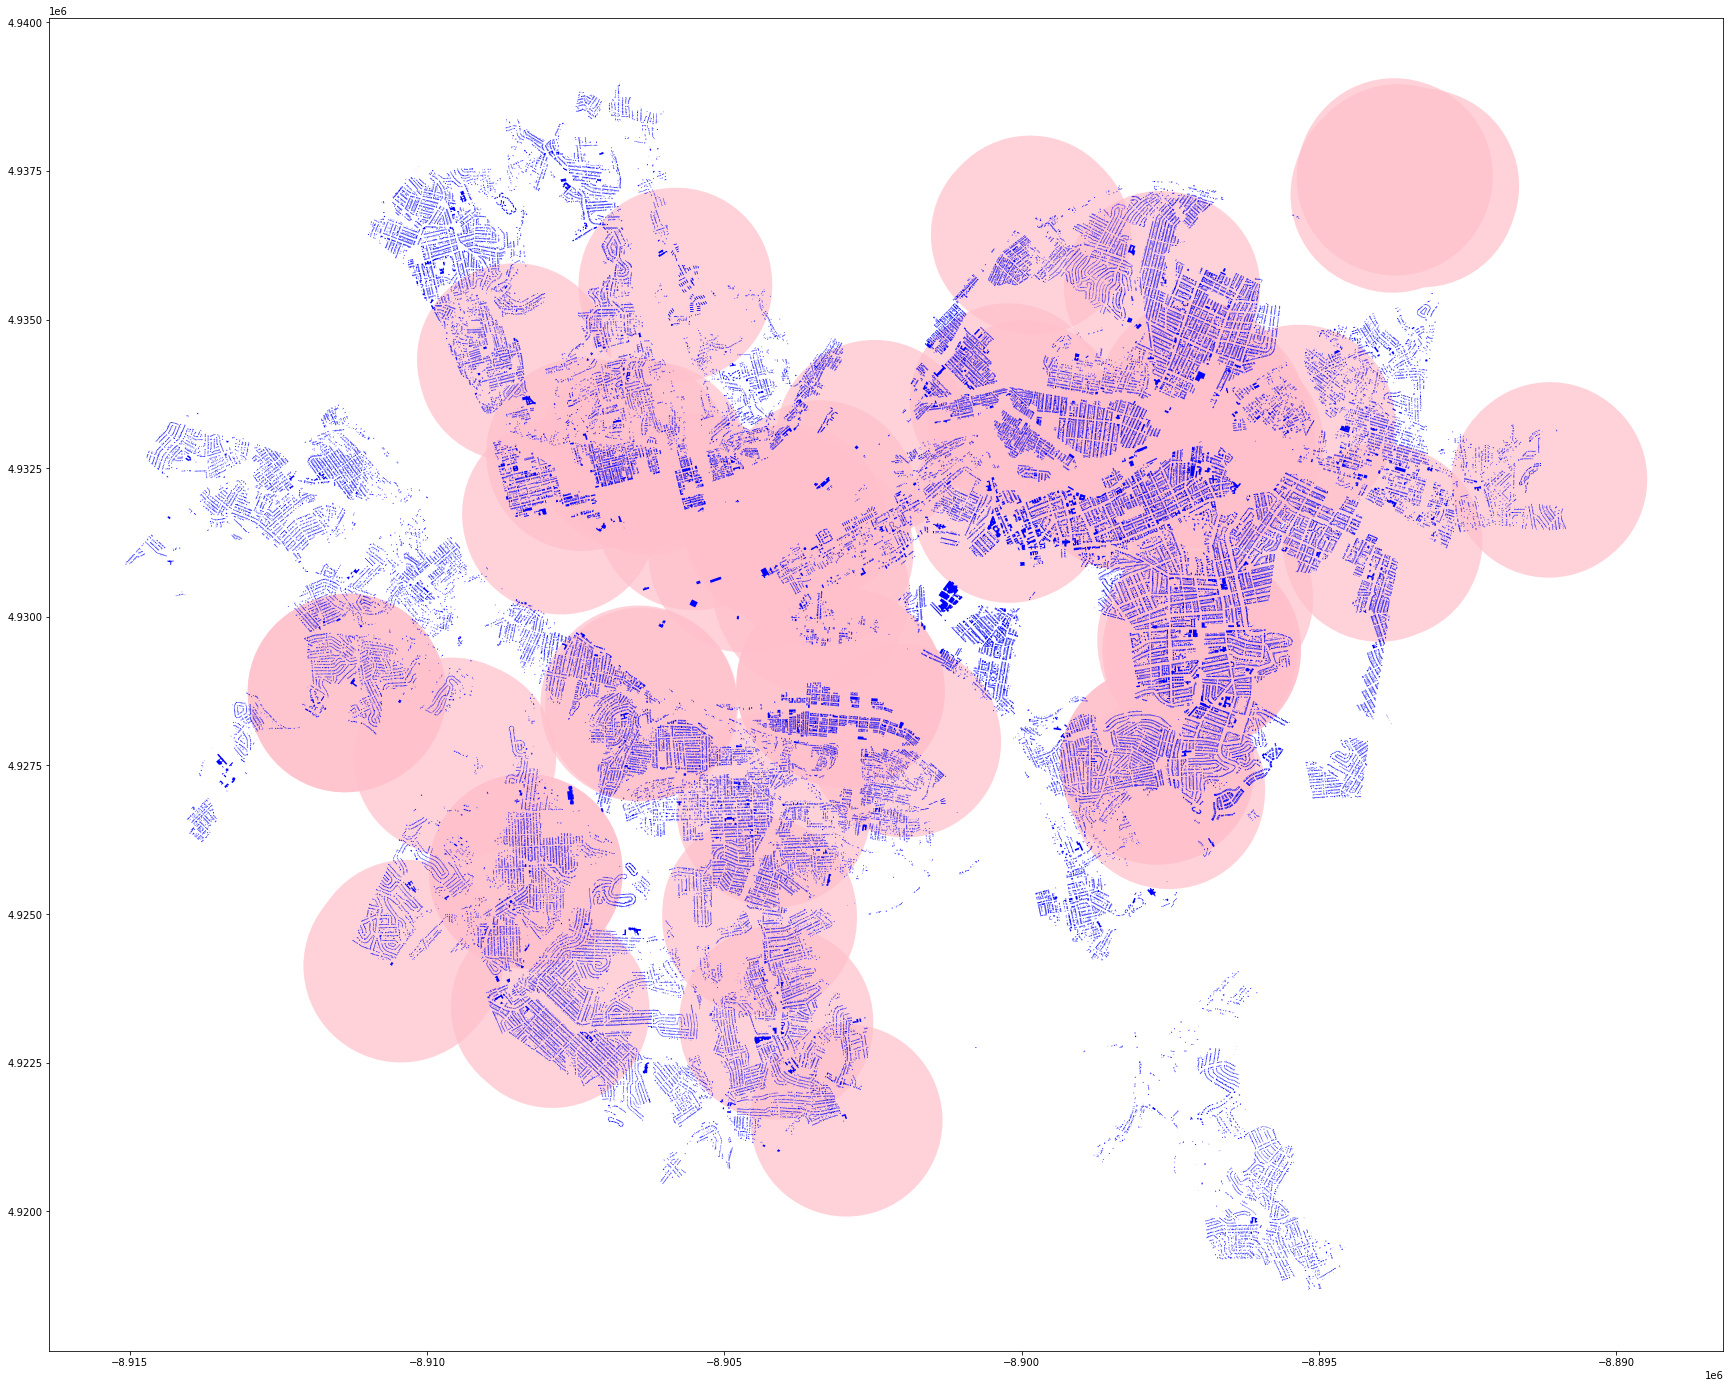

In [27]:
# Plot 1 mile and half mile
buildings_df = gpd.read_file('../processed_data/relevant_buildings.shp')

# Splitting up grocery stores data to add buffers
grocery_stores = buildings_df[buildings_df['class_reco'].str.contains('Grocery')]
grocery_stores['geometry'] = grocery_stores['geometry'].to_crs(epsg=3857) # converting to this CRS changes the units to meters
grocery_stores['geometry'] = grocery_stores['geometry'].buffer(1609.34) # 1609 meters = 1 mile - buffering adds a buffer around the point with this radius

res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings['geometry'] = res_buildings['geometry'].to_crs(epsg=3857)

# plotting
f, ax = plt.subplots(figsize=(30,30))
grocery_stores.plot(ax=ax, alpha=0.7, color='pink', label='Grocery stores + 1 mile buffer')
res_buildings.plot(ax=ax, color='blue', label='Residential buildings')


<AxesSubplot:>

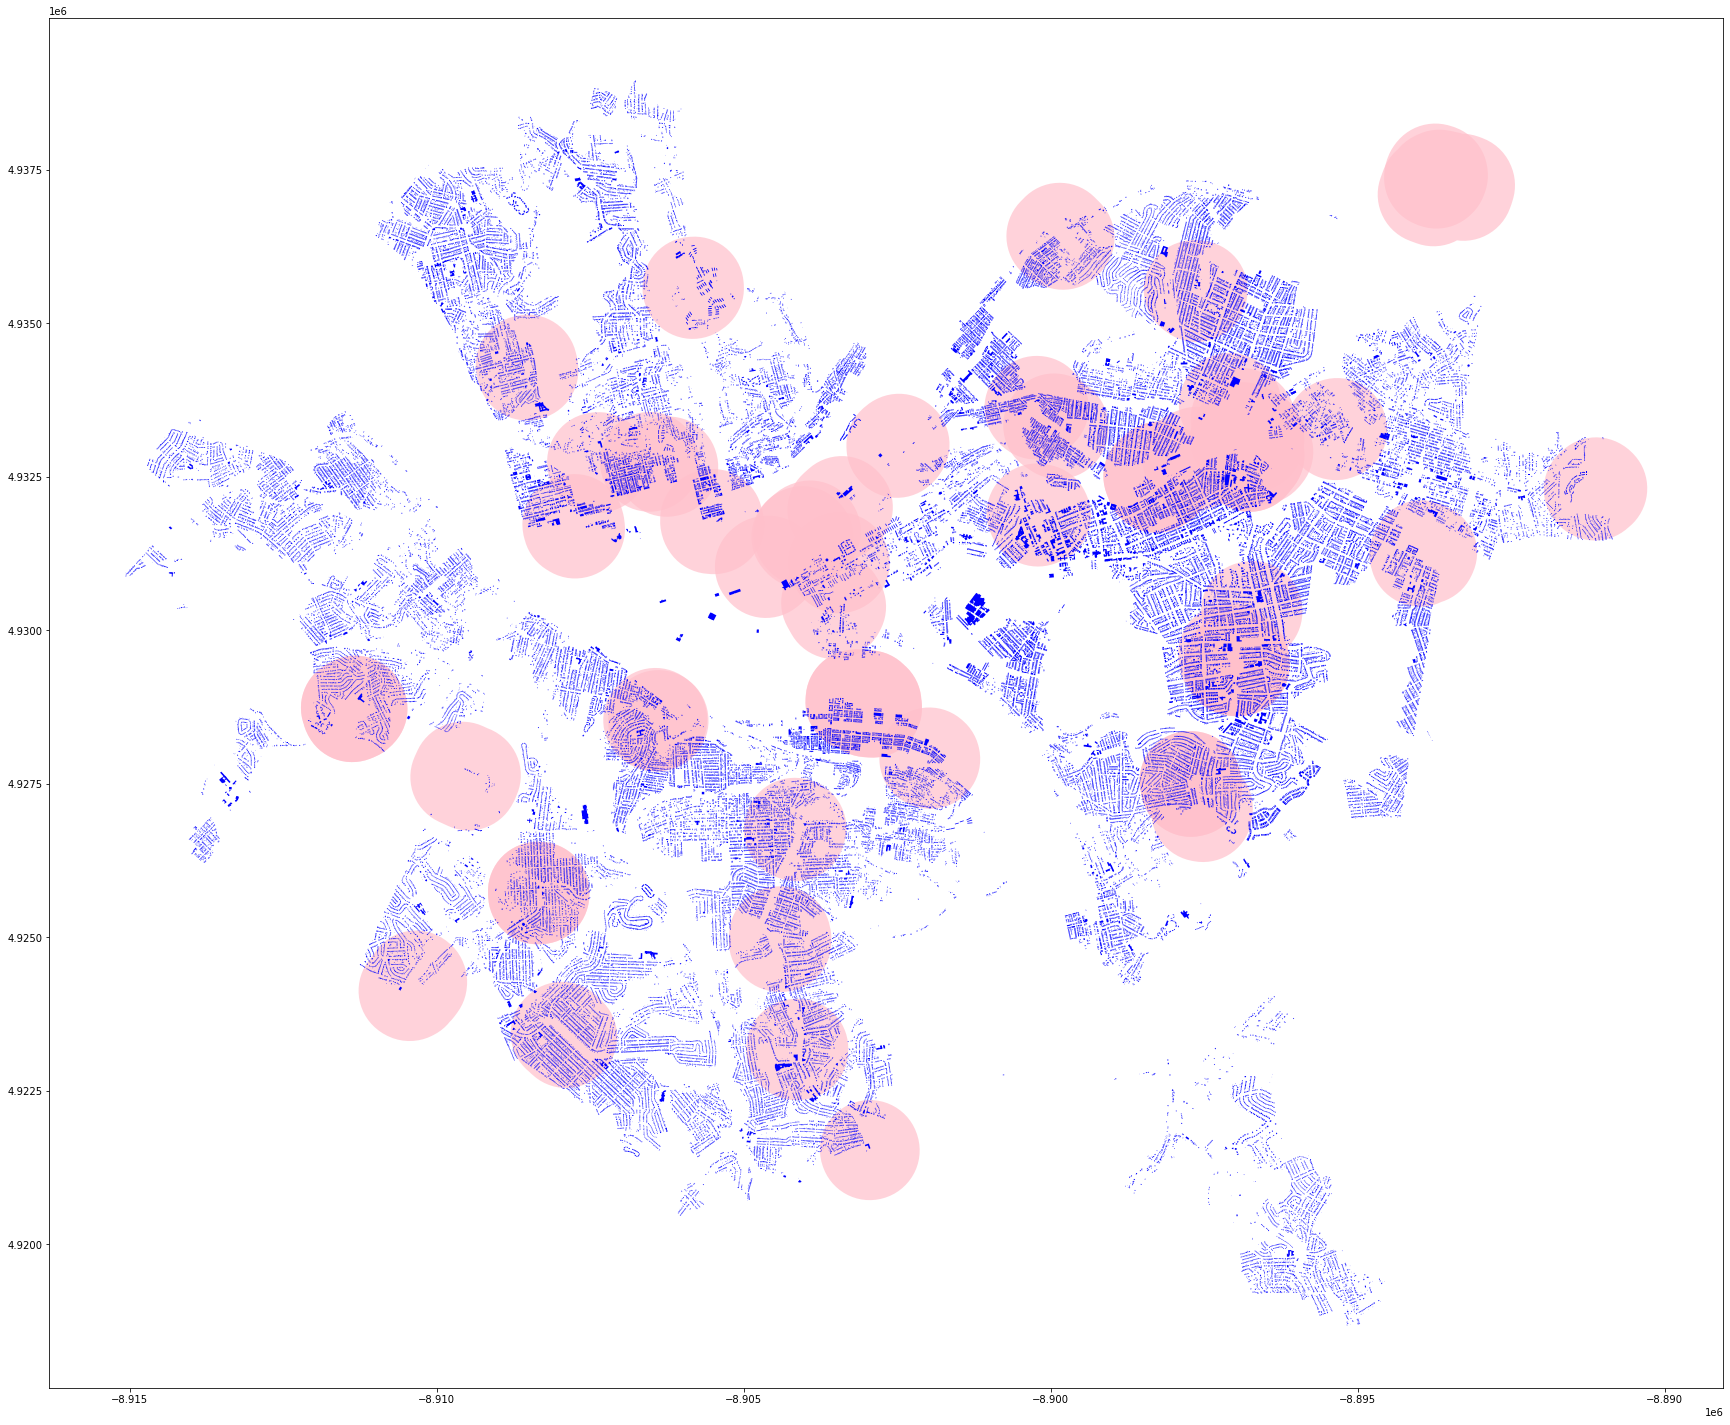

In [28]:
# Plot 1 mile and half mile
buildings_df = gpd.read_file('../processed_data/relevant_buildings.shp')

# Splitting up grocery stores data to add buffers
grocery_stores = buildings_df[buildings_df['class_reco'].str.contains('Grocery')]
grocery_stores['geometry'] = grocery_stores['geometry'].to_crs(epsg=3857) # converting to this CRS changes the units to meters
grocery_stores['geometry'] = grocery_stores['geometry'].buffer(804.67) # 1609 meters = 1 mile - buffering adds a buffer around the point with this radius

res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings['geometry'] = res_buildings['geometry'].to_crs(epsg=3857)

# plotting
f, ax = plt.subplots(figsize=(30,30))
grocery_stores.plot(ax=ax, alpha=0.7, color='pink', label='Grocery stores + 1 mile buffer')
res_buildings.plot(ax=ax, color='blue', label='Residential buildings')